In [1]:
import torch
import numpy as np
from pandas import factorize, DataFrame
from copy import deepcopy
from matplotlib import pyplot as plt

from uncertain.models.ExplicitFactorizationModel import ExplicitFactorizationModel
from uncertain.models.UncertainWrapper import UncertainWrapper, LinearUncertaintyEstimator
from uncertain.models.multimodelling import EnsembleRecommender, ResampleRecommender
from uncertain.cross_validation import user_based_split, random_train_test_split
from uncertain.interactions import Interactions
from uncertain.models.CPMF import CPMF
from uncertain.models.OrdRec import OrdRec
from uncertain.datasets.movielens import get_movielens_dataset

from utils import evaluate

train = get_movielens_dataset('1M')
train, test = random_train_test_split(train, test_percentage=0.2, random_state=0)
train.gpu()
test.gpu()

MF_params = {'embedding_dim': 10, 'n_iter': 100, 'l2': 3e-5,
             'learning_rate': 0.005, 'batch_size': 2048, 'use_cuda': True}
CPMF_params = {'embedding_dim': 10, 'n_iter': 100, 'l2_base': 3e-5, 'l2_var': 5e-5,
               'learning_rate': 0.005, 'batch_size': 2048, 'use_cuda': True}
OrdRec_params = {'embedding_dim': 10, 'n_iter': 100, 'l2_base': 5e-6, 'l2_step': 3e-6,
                 'learning_rate': 0.005, 'batch_size': 2048, 'use_cuda': True}

models = {}

In [2]:
models['Baseline'] = ExplicitFactorizationModel(**MF_params)
models['Baseline'].fit(train)
models['Baseline'].evaluation = evaluate(models['Baseline'], test, train, uncertainty=False)
models['Baseline'].evaluation

FunkSVD: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s, Epoch 100 loss: 0.6865198718922217]


{'RMSE': tensor(0.8736, device='cuda:0'),
 'Precision': tensor([0.2163, 0.1979, 0.1828, 0.1714, 0.1619, 0.1551, 0.1490, 0.1443, 0.1398,
         0.1356], device='cuda:0'),
 'Recall': tensor([0.0156, 0.0279, 0.0381, 0.0483, 0.0559, 0.0642, 0.0712, 0.0785, 0.0850,
         0.0917], device='cuda:0')}

In [3]:
models['User support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(-train.get_user_support(), None))
models['User support'].evaluation = evaluate(models['User support'], test, train, uncertainty=True)
models['User support'].evaluation

{'RMSE': tensor(0.8736, device='cuda:0'),
 'Precision': tensor([0.2163, 0.1979, 0.1828, 0.1714, 0.1619, 0.1551, 0.1490, 0.1443, 0.1398,
         0.1356], device='cuda:0'),
 'Recall': tensor([0.0156, 0.0279, 0.0381, 0.0483, 0.0559, 0.0642, 0.0712, 0.0785, 0.0850,
         0.0917], device='cuda:0'),
 'Quantile RMSE': tensor([0.8408, 0.8419, 0.8379, 0.8638, 0.8453, 0.8636, 0.8309, 0.8454, 0.8352,
         0.8549, 0.8487, 0.8547, 0.8808, 0.8996, 0.8843, 0.8863, 0.8759, 0.9161,
         0.9450, 0.9969]),
 'Quantile MAP': tensor([0.4054, 0.3007, 0.2342, 0.2184, 0.1762, 0.1718, 0.1465, 0.1316, 0.1265,
         0.1082, 0.1049, 0.0959, 0.0903, 0.0872, 0.0642, 0.0611, 0.0628, 0.0569,
         0.0391, 0.0393]),
 'RRI': tensor([nan, nan, nan, nan, nan, -inf, nan, nan, nan]),
 'Correlation': (tensor(0.0413, device='cuda:0'),
  tensor(0.0516, device='cuda:0')),
 'RPI': tensor(0.1212, device='cuda:0'),
 'Classification': (-0.549418995058184, 0.53205990816014)}

In [4]:
models['Item support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, -train.get_item_support()))
models['Item support'].evaluation = evaluate(models['Item support'], test, train, uncertainty=True)
models['Item support'].evaluation

{'RMSE': tensor(0.8736, device='cuda:0'),
 'Precision': tensor([0.2163, 0.1979, 0.1828, 0.1714, 0.1619, 0.1551, 0.1490, 0.1443, 0.1398,
         0.1356], device='cuda:0'),
 'Recall': tensor([0.0156, 0.0279, 0.0381, 0.0483, 0.0559, 0.0642, 0.0712, 0.0785, 0.0850,
         0.0917], device='cuda:0'),
 'Quantile RMSE': tensor([0.8000, 0.8047, 0.8348, 0.8655, 0.8906, 0.8272, 0.8526, 0.8443, 0.8736,
         0.8511, 0.8683, 0.8498, 0.8619, 0.8641, 0.8549, 0.8774, 0.8797, 0.9036,
         0.9218, 1.0909]),
 'Quantile MAP': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RRI': tensor([0.2128, 0.3105, 0.3547, 0.4072, 0.4283, 0.4529, 0.4657, 0.4842, 0.4974]),
 'Correlation': (tensor(0.0618, device='cuda:0'),
  tensor(0.0621, device='cuda:0')),
 'RPI': tensor(0.1840, device='cuda:0'),
 'Classification': (-0.5484234307659179, 0.5412766331305577)}

In [5]:
models['Item variance'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, train.get_item_variance()))
models['Item variance'].evaluation = evaluate(models['Item variance'], test, train, uncertainty=True)
models['Item variance'].evaluation

{'RMSE': tensor(0.8736, device='cuda:0'),
 'Precision': tensor([0.2163, 0.1979, 0.1828, 0.1714, 0.1619, 0.1551, 0.1490, 0.1443, 0.1398,
         0.1356], device='cuda:0'),
 'Recall': tensor([0.0156, 0.0279, 0.0381, 0.0483, 0.0559, 0.0642, 0.0712, 0.0785, 0.0850,
         0.0917], device='cuda:0'),
 'Quantile RMSE': tensor([0.7865, 0.7552, 0.7669, 0.7806, 0.8053, 0.8369, 0.8380, 0.8368, 0.8439,
         0.8640, 0.8735, 0.8620, 0.8849, 0.8888, 0.9015, 0.9041, 0.9495, 0.9460,
         0.9708, 1.1027]),
 'Quantile MAP': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RRI': tensor([-0.0148, -0.0507, -0.0783, -0.0835, -0.1008, -0.1076, -0.1054, -0.1086,
         -0.1102]),
 'Correlation': (tensor(0.1272, device='cuda:0'),
  tensor(0.1091, device='cuda:0')),
 'RPI': tensor(0.4299, device='cuda:0'),
 'Classification': (-0.5437842592743181, 0.5741893681553087)}

In [6]:
models['Ensemble'] = EnsembleRecommender(base_model=models['Baseline'], n_models=10)
models['Ensemble'].fit(train)
models['Ensemble'].evaluation = evaluate(models['Ensemble'], test, train, uncertainty=True)
models['Ensemble'].evaluation

Ensemble: 100%|██████████| 9/9 [07:17<00:00, 48.61s/it]


{'RMSE': tensor(0.8705, device='cuda:0'),
 'Precision': tensor([0.2228, 0.2011, 0.1848, 0.1732, 0.1648, 0.1574, 0.1514, 0.1451, 0.1413,
         0.1371], device='cuda:0'),
 'Recall': tensor([0.0159, 0.0287, 0.0392, 0.0491, 0.0577, 0.0653, 0.0724, 0.0788, 0.0858,
         0.0924], device='cuda:0'),
 'Quantile RMSE': tensor([0.8646, 0.8163, 0.8259, 0.8226, 0.8203, 0.8344, 0.8395, 0.8404, 0.8466,
         0.8411, 0.8600, 0.8665, 0.8631, 0.8728, 0.8912, 0.8894, 0.9019, 0.9096,
         0.9365, 1.0391]),
 'Quantile MAP': tensor([0.1007, 0.1173, 0.1203, 0.1204, 0.1210, 0.1103, 0.1387, 0.1231, 0.1487,
         0.1230, 0.1370, 0.1450, 0.1452, 0.1310, 0.1473, 0.1562, 0.1470, 0.1737,
         0.1677, 0.1696]),
 'RRI': tensor([-0.0490, -0.0696, -0.0768, -0.0825, -0.0874, -0.0818, -0.0921, -0.1023,
         -0.1092]),
 'Correlation': (tensor(0.0794, device='cuda:0'),
  tensor(0.0598, device='cuda:0')),
 'RPI': tensor(0.3546, device='cuda:0'),
 'Classification': (-0.5461032818675302, 0.538905750921

In [7]:
models['Resample'] = ResampleRecommender(base_model=models['Baseline'], n_models=10)
models['Resample'].fit(train)
models['Resample'].evaluation = evaluate(models['Resample'], test, train, uncertainty=True)
models['Resample'].evaluation

Resample: 100%|██████████| 10/10 [06:58<00:00, 41.85s/it]


{'RMSE': tensor(0.8736, device='cuda:0'),
 'Precision': tensor([0.2163, 0.1979, 0.1828, 0.1714, 0.1619, 0.1551, 0.1490, 0.1443, 0.1398,
         0.1356], device='cuda:0'),
 'Recall': tensor([0.0156, 0.0279, 0.0381, 0.0483, 0.0559, 0.0642, 0.0712, 0.0785, 0.0850,
         0.0917], device='cuda:0'),
 'Quantile RMSE': tensor([0.8194, 0.8133, 0.8079, 0.8188, 0.8252, 0.8222, 0.8411, 0.8369, 0.8568,
         0.8538, 0.8629, 0.8726, 0.8738, 0.8722, 0.8923, 0.8972, 0.9194, 0.9354,
         0.9551, 1.0563]),
 'Quantile MAP': tensor([0.1997, 0.1963, 0.1847, 0.1669, 0.1673, 0.1577, 0.1460, 0.1338, 0.1300,
         0.1413, 0.1433, 0.1140, 0.1307, 0.1173, 0.1187, 0.1114, 0.0933, 0.0987,
         0.0890, 0.0726]),
 'RRI': tensor([ 0.0047,  0.0004,  0.0023,  0.0046, -0.0021, -0.0090, -0.0109, -0.0084,
         -0.0047]),
 'Correlation': (tensor(0.0923, device='cuda:0'),
  tensor(0.0709, device='cuda:0')),
 'RPI': tensor(0.3571, device='cuda:0'),
 'Classification': (-0.5473565359574584, 0.545720503335

In [8]:
fold1, fold2 = random_train_test_split(train, random_state=0, test_percentage=0.5)
model_cv = deepcopy(models['Baseline'])
model_cv._initialize(fold1)
model_cv.fit(fold1)
predictions1 = model_cv.predict(fold2.user_ids, fold2.item_ids)
model_cv._initialize(fold2)
model_cv.fit(fold2)
predictions2 = model_cv.predict(fold1.user_ids, fold1.item_ids)
train_errors = torch.cat((torch.abs(fold2.ratings - predictions1), torch.abs(fold1.ratings - predictions2)))
train_errors = Interactions(torch.cat((fold2.user_ids, fold1.user_ids)),
                            torch.cat((fold2.item_ids, fold1.item_ids)),
                            train_errors, num_users=train.num_users, num_items=train.num_items)

In [9]:
models['FCV'] = ExplicitFactorizationModel(**MF_params)
models['FCV'].fit(train_errors)
models['FCV'] = UncertainWrapper(models['Baseline'], models['FCV'])
models['FCV'].evaluation = evaluate(models['FCV'], test, train, uncertainty=True)
models['FCV'].evaluation

FunkSVD: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s, Epoch 100 loss: 0.3034316937027075]


{'RMSE': tensor(0.8736, device='cuda:0'),
 'Precision': tensor([0.2163, 0.1979, 0.1828, 0.1714, 0.1619, 0.1551, 0.1490, 0.1443, 0.1398,
         0.1356], device='cuda:0'),
 'Recall': tensor([0.0156, 0.0279, 0.0381, 0.0483, 0.0559, 0.0642, 0.0712, 0.0785, 0.0850,
         0.0917], device='cuda:0'),
 'Quantile RMSE': tensor([0.8426, 0.7394, 0.7306, 0.7451, 0.7528, 0.7700, 0.7858, 0.7917, 0.8099,
         0.8285, 0.8375, 0.8613, 0.8785, 0.8934, 0.9210, 0.9308, 0.9584, 1.0113,
         1.0610, 1.1737]),
 'Quantile MAP': tensor([0.0847, 0.0890, 0.1200, 0.1097, 0.1207, 0.1173, 0.1393, 0.1284, 0.1480,
         0.1407, 0.1383, 0.1629, 0.1713, 0.1563, 0.1447, 0.1672, 0.1463, 0.1433,
         0.1470, 0.1375]),
 'RRI': tensor([-0.0126, -0.0322, -0.0411, -0.0397, -0.0559, -0.0647, -0.0676, -0.0773,
         -0.0816]),
 'Correlation': (tensor(0.1731, device='cuda:0'),
  tensor(0.1619, device='cuda:0')),
 'RPI': tensor(0.5762, device='cuda:0'),
 'Classification': (-0.5387638753148974, 0.603216276052

In [10]:
MF_params['embedding_dim'] = 0
models['BCV'] = ExplicitFactorizationModel(**MF_params)
models['BCV'].fit(train_errors)
models['BCV'] = UncertainWrapper(models['Baseline'], models['BCV'])
models['BCV'].evaluation = evaluate(models['BCV'], test, train, uncertainty=True)
models['BCV'].evaluation

Linear recommender: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, Epoch 100 loss: 0.30041586605789106]


{'RMSE': tensor(0.8736, device='cuda:0'),
 'Precision': tensor([0.2163, 0.1979, 0.1828, 0.1714, 0.1619, 0.1551, 0.1490, 0.1443, 0.1398,
         0.1356], device='cuda:0'),
 'Recall': tensor([0.0156, 0.0279, 0.0381, 0.0483, 0.0559, 0.0642, 0.0712, 0.0785, 0.0850,
         0.0917], device='cuda:0'),
 'Quantile RMSE': tensor([0.6402, 0.6779, 0.7014, 0.7080, 0.7398, 0.7536, 0.7796, 0.8000, 0.8203,
         0.8234, 0.8611, 0.8785, 0.8870, 0.9090, 0.9394, 0.9584, 0.9957, 1.0310,
         1.0976, 1.2250]),
 'Quantile MAP': tensor([0.1707, 0.1620, 0.1600, 0.1666, 0.1293, 0.1560, 0.1570, 0.1445, 0.1510,
         0.1453, 0.1447, 0.1331, 0.1307, 0.1163, 0.1237, 0.1167, 0.1180, 0.0960,
         0.0997, 0.0913]),
 'RRI': tensor([-0.0155, -0.0447, -0.0620, -0.0647, -0.0853, -0.0987, -0.1007, -0.1019,
         -0.0995]),
 'Correlation': (tensor(0.2354, device='cuda:0'),
  tensor(0.2060, device='cuda:0')),
 'RPI': tensor(0.7857, device='cuda:0'),
 'Classification': (-0.5297729562036393, 0.634080286841

In [11]:
models['CPMF'] = CPMF(**CPMF_params)
models['CPMF'].fit(train)
models['CPMF'].evaluation = evaluate(models['CPMF'], test, train, uncertainty=True)
models['CPMF'].evaluation

CPMF: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s, Epoch 100 loss: 0.5141811832747496]


{'RMSE': tensor(0.8651, device='cuda:0'),
 'Precision': tensor([0.2155, 0.1921, 0.1771, 0.1669, 0.1566, 0.1495, 0.1434, 0.1386, 0.1342,
         0.1304], device='cuda:0'),
 'Recall': tensor([0.0149, 0.0258, 0.0353, 0.0440, 0.0512, 0.0592, 0.0655, 0.0720, 0.0789,
         0.0848], device='cuda:0'),
 'Quantile RMSE': tensor([0.5952, 0.6369, 0.6659, 0.6971, 0.7221, 0.7475, 0.7664, 0.7804, 0.8124,
         0.8301, 0.8570, 0.8761, 0.8891, 0.9074, 0.9452, 0.9578, 1.0034, 1.0297,
         1.0968, 1.2063]),
 'Quantile MAP': tensor([0.2510, 0.1887, 0.1673, 0.1515, 0.1417, 0.1373, 0.1137, 0.1207, 0.1023,
         0.1010, 0.0953, 0.1087, 0.1117, 0.1103, 0.1100, 0.1027, 0.1230, 0.1133,
         0.1257, 0.1328]),
 'RRI': tensor([0.0683, 0.0821, 0.0834, 0.1010, 0.1078, 0.1060, 0.1076, 0.1053, 0.1037]),
 'Correlation': (tensor(0.2485, device='cuda:0'),
  tensor(0.2211, device='cuda:0')),
 'RPI': tensor(0.8354, device='cuda:0'),
 'Classification': (-0.521842369260591, 0.6454050959017623)}

In [12]:
factor = factorize(train.ratings.cpu(), sort=True)
rating_labels = torch.from_numpy(factor[1].astype(np.float64)).cuda()
train.ratings = torch.from_numpy(factor[0]).cuda()

models['OrdRec'] = OrdRec(rating_labels, **OrdRec_params)
models['OrdRec'].fit(train)
models['OrdRec'].evaluation = evaluate(models['OrdRec'], test, train, uncertainty=True)
models['OrdRec'].evaluation

OrdRec: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it, Epoch 100 loss: -0.4451074840315163]


{'RMSE': tensor(0.9323, device='cuda:0', dtype=torch.float64),
 'Precision': tensor([0.2410, 0.2165, 0.1992, 0.1882, 0.1783, 0.1699, 0.1634, 0.1568, 0.1515,
         0.1465], device='cuda:0'),
 'Recall': tensor([0.0164, 0.0284, 0.0383, 0.0486, 0.0572, 0.0644, 0.0723, 0.0794, 0.0858,
         0.0918], device='cuda:0'),
 'Quantile RMSE': tensor([0.7540, 0.8084, 0.8615, 0.8580, 0.8510, 0.8600, 0.8400, 0.8606, 0.8924,
         0.8961, 0.9143, 0.9374, 0.9546, 0.9535, 0.9728, 0.9933, 1.0262, 1.0456,
         1.0751, 1.1839]),
 'Quantile MAP': tensor([0.3520, 0.2797, 0.2303, 0.2251, 0.2107, 0.2053, 0.1697, 0.1575, 0.1513,
         0.1187, 0.1097, 0.0900, 0.0893, 0.0803, 0.0773, 0.0896, 0.0857, 0.0777,
         0.0710, 0.0589]),
 'RRI': tensor([0.0898, 0.1311, 0.1492, 0.1707, 0.1964, 0.2053, 0.2165, 0.2162, 0.2279]),
 'Correlation': (tensor(0.1933, device='cuda:0', dtype=torch.float64),
  tensor(0.2726, device='cuda:0', dtype=torch.float64)),
 'RPI': tensor(0.4133, device='cuda:0', dtype=torch

In [13]:
keys = ['Baseline', 'Ensemble', 'CPMF', 'OrdRec']
rmse = [models[key].evaluation['RMSE'].item() for key in keys]
DataFrame(rmse, index=keys, columns=['RMSE'])

,RMSE
Baseline,0.873603
Ensemble,0.870538
CPMF,0.865063
OrdRec,0.932256


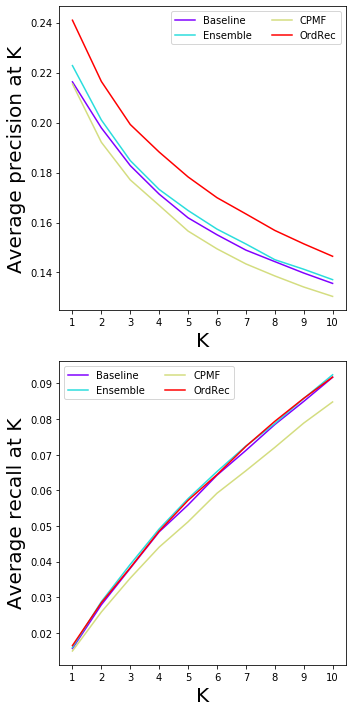

In [14]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
f, ax = plt.subplots(nrows=2, figsize=(5, 10))
for key in keys:
    c = next(color)
    ax[0].plot(np.arange(1, 11), models[key].evaluation['Precision'].cpu().detach().numpy(), '-', color=c, label=key)
    ax[1].plot(np.arange(1, 11), models[key].evaluation['Recall'].cpu().detach().numpy(), '-', color=c, label=key)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', Fontsize=20)
ax[0].set_ylabel('Average precision at K', Fontsize=20)
ax[0].legend(ncol=2)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xticklabels(np.arange(1, 11))
ax[1].set_xlabel('K', Fontsize=20)
ax[1].set_ylabel('Average recall at K', Fontsize=20)
ax[1].legend(ncol=2)
f.tight_layout()

In [15]:
keys = list(models.keys())[1:]
out = DataFrame(np.zeros((3, 9)), index=['RPI', 'Pearson', 'Spearman'], columns=keys)
for key in keys:
    out[key] = (models[key].evaluation['RPI'].item(), 
                models[key].evaluation['Correlation'][0].item(), 
                models[key].evaluation['Correlation'][1].item())
out.T

,RPI,Pearson,Spearman
User support,0.121184,0.041329,0.051633
Item support,0.184045,0.061804,0.062128
Item variance,0.429871,0.127197,0.109148
Ensemble,0.354635,0.079437,0.059837
Resample,0.357121,0.092264,0.070850
FCV,0.576225,0.173066,0.161937
BCV,0.785689,0.235371,0.205985
CPMF,0.835381,0.248535,0.221133
OrdRec,0.413340,0.193260,0.272616


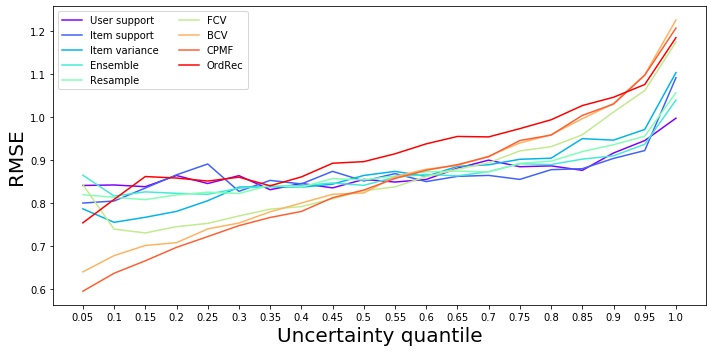

In [16]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), models[key].evaluation['Quantile RMSE'], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

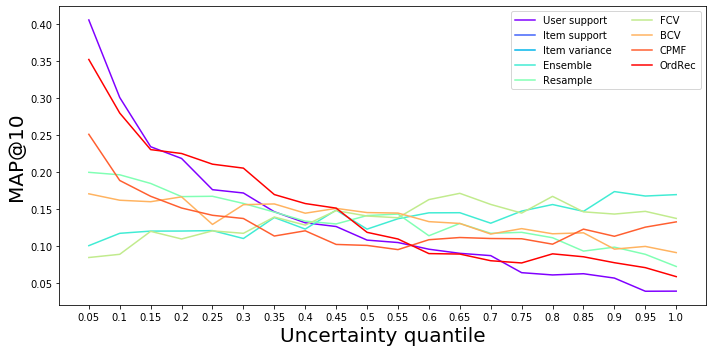

In [17]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), models[key].evaluation['Quantile MAP'], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('MAP@10', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

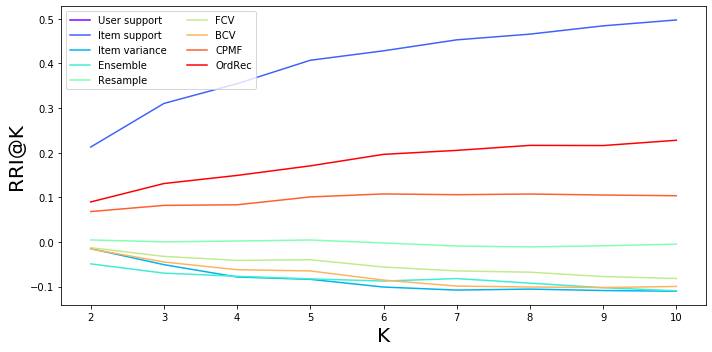

In [18]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(2, 11), models[key].evaluation['RRI'], '-', color=c, label=key)
ax.set_xlabel('K', Fontsize=20)
ax.set_ylabel('RRI@K', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

In [19]:
results = DataFrame((np.zeros((2, 9))), index=['Likelihood', 'AUC'], columns=keys)
for key in keys:
    results[key] = models[key].evaluation['Classification']
results.T

,Likelihood,AUC
User support,-0.549419,0.532060
Item support,-0.548423,0.541277
Item variance,-0.543784,0.574189
Ensemble,-0.546103,0.538906
Resample,-0.547357,0.545721
FCV,-0.538764,0.603216
BCV,-0.529773,0.634080
CPMF,-0.521842,0.645405
OrdRec,-0.537326,0.610160
